توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as v2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split
import torchvision.transforms.functional as TF
from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tqdm import tqdm
from torch.optim import lr_scheduler
import copy
from sklearn.metrics import precision_recall_fscore_support
import time
from collections import defaultdict
from sklearn.metrics import accuracy_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [ ]:
# function 1
def displacement(img):
    img = img.numpy().transpose(1,2,0)
    # Generate random displacement values for x and y axes
    dx = np.random.randint(30,80)
    dy = np.random.randint(30,80)

    # Create a transformation matrix for translation
    M = np.float32([[1, 0, dx], [0, 1, dy]])

    # Apply the translation to the image using warpAffine function
    translated_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]),borderMode=cv2.BORDER_REFLECT)
    return torch.tensor(translated_img.transpose(2,0,1))

# function 2
def rotation(img):

    img = img.numpy().transpose(1,2,0)
    angle = np.random.randint(-30, 30)
    height, width = img.shape[:2]
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)

    # Apply the rotation to the image
    rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height),borderMode=cv2.BORDER_REFLECT)

    return torch.from_numpy(rotated_img.transpose(2,0,1))

# # function 2
# def rotation(img):
#   rotator = v2.RandomRotation(degrees=(-90,90))
#   crop = v2.CenterCrop(size=(img.shape[1]//2, img.shape[2]//2))
#   # rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
#   # rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height),borderMode=cv2.BORDER_REFLECT)
#   return torch.tensor(crop(rotator(img)))

# function 3
# def scaling(img):
#     scale_coeff = np.random.uniform(0.7, 1.25)
#     height, width = img.shape[0],img.shape[1]
#     # Resize the image to the new dimensions
#     scaled_img = cv2.resize(img,
#                   (int(height * scale_coeff), int(width * scale_coeff)),
#                             interpolation=cv2.INTER_AREA)

#     return scaled_img


# function 3
def scaling(img):
  # scaled_img = cv2.resize(img,(int(height * scale_coeff), int(width * scale_coeff)),
  #                       interpolation=cv2.INTER_AREA)
  displacement_transfomer = v2.RandomAffine(degrees=0,scale=(1,4))
  return displacement_transfomer(img)


# function 4
def Brightness(img):  ## for augmentation
    # hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # brightness_coeff = np.random.uniform(0.5, 1.5)
    # hsv_img[:,:,2] = hsv_img[:,:,2] * brightness_coeff
    # augmented_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)

    brightness_coeff = np.random.uniform(0.5, 1.5)
    return TF.adjust_brightness(img, brightness_coeff)



# function 5
def bluring(img):# for augmentation
  # for _ in range(5):
  #     img = cv2.filter2D(img, -1, np.array([[1/4, 1/2, 1/4]]))
  #     img = cv2.filter2D(img, -1, np.array([[1/4], [1/2], [1/4]]))
  blurr_trnsfrm = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
  return blurr_trnsfrm(img)

# function 6
def gaussian_noise(img):#for augmentation
    # noise = np.random.normal(0, 10, size=img.shape)
    # noisy_img = img + noise
    # noisy_img = np.clip(img, 0, 255)
    std = 20
    type_ = img.dtype
    img = img.type(torch.float64)
    img += torch.from_numpy(np.random.normal(0, std, size=img.shape))
    return img.type(type_)

Test the above functions:

In [ ]:
def plot_image(img,text):
    img = img.numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.title(text)
    plt.axis("off")


In [ ]:
test_img2 = Image.open(f'/content/ADEChallengeData2016/images/training/ADE_train_00000002.jpg')

transform = v2.Compose([v2.PILToTensor()])

test_img2 = transform(test_img2)
test_img2.shape

torch.Size([3, 512, 711])

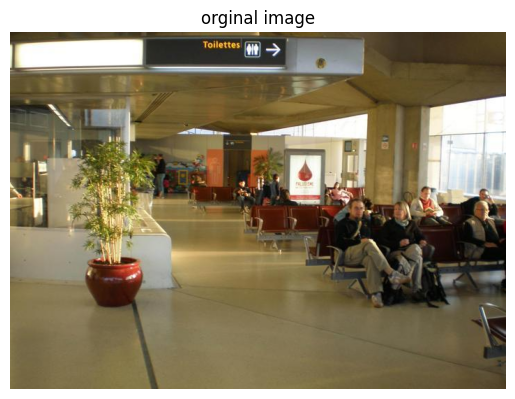

In [ ]:
plot_image(test_img2,'orginal image')

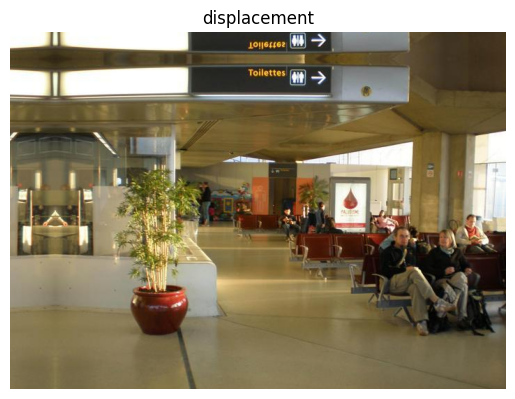

In [ ]:
plot_image(displacement(test_img2),'displacement')

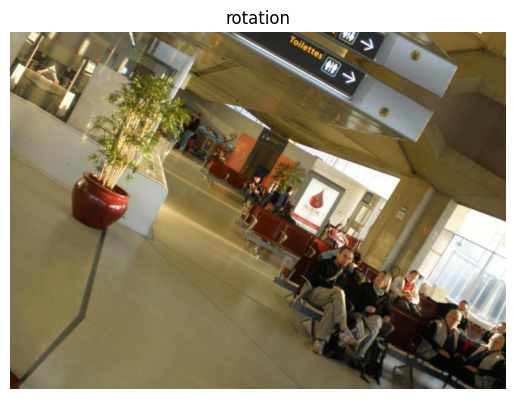

In [ ]:
plot_image(rotation(test_img2),'rotation')

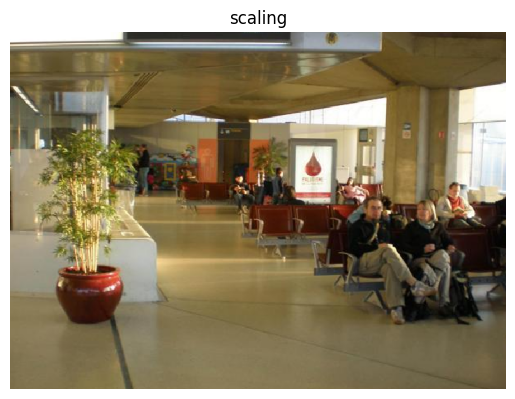

In [ ]:
plot_image(scaling(test_img2),'scaling')

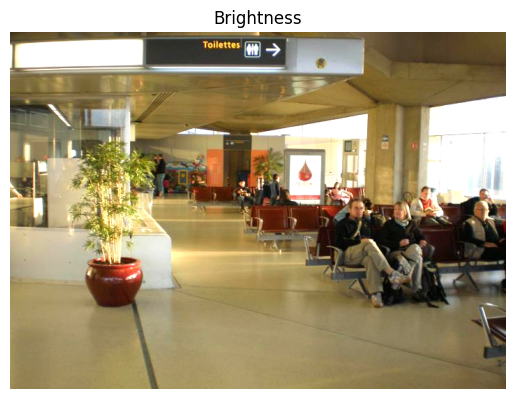

In [ ]:
plot_image(Brightness(test_img2),'Brightness')

torch.Tensor

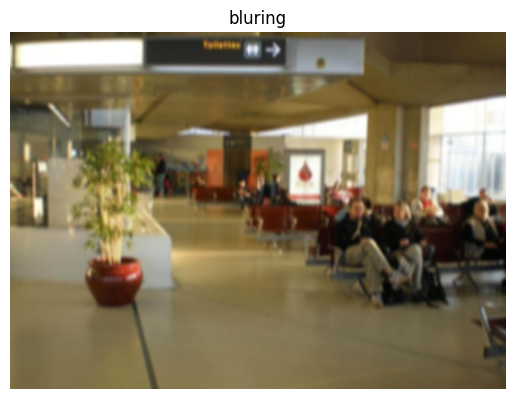

In [ ]:
plot_image(bluring(test_img2),'bluring')

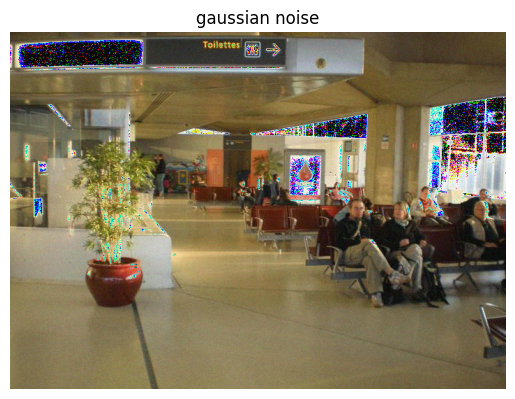

In [ ]:
plot_image(gaussian_noise(test_img2),'gaussian noise')

In [ ]:
def plot_multi_image(images,label=None,title=None):
    fig, axes = plt.subplots(nrows=1, ncols=images.shape[0],figsize=(20, 20))

    for index,ax in enumerate(axes):
      ax.imshow(images[index].numpy().transpose(1, 2, 0))
      ax.axis("off")
      if label is not None:
        ax.set_title([int(x) for x in label[index].tolist()])
      if title is not None :
        ax.set_title(title)

## Dataset class

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = os.listdir(data_dir)

    def augmentor(self, img):
        changed_img = img.clone()
        transforms = [displacement, rotation, scaling]

        # apply 0, 1 or 2 transformation
        label = torch.ones(3,device = img.device)
        while label.sum() == 3:
          label = torch.zeros(3,device = img.device)
          for index in range(3):
              label[index] = np.random.randint(0,2)

        for index,a in enumerate(label):
            if a > 0.5:
                transform_function = transforms[index]
                changed_img = transform_function(changed_img)

        return changed_img,label


    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.images[idx])
        img = Image.open(img_name)

        if self.transform:
            img = self.transform(img)

        if img.shape[0] == 1:
            img = img.expand(3,-1,-1)

        augmented_img,label = self.augmentor(img)

        # img = v2.CenterCrop(size=(img.shape[1]//2, img.shape[2]//2))(img)
        return v2.Resize((224,224),antialias=True)(img), v2.Resize((224,224),antialias=True)(augmented_img), label

    def __len__(self):
        return len(self.images)


In [ ]:
transform_orig = v2.Compose([v2.PILToTensor()])

# apply data augmentation on training dataset using function 4,5,6
augmentor1 = v2.Compose([
    v2.PILToTensor(),
    Brightness,
    gaussian_noise,
    bluring
    ])

train_org = CustomDataset('/content/ADEChallengeData2016/images/training',transform=transform_orig)## To Do
train_aug = CustomDataset('/content/ADEChallengeData2016/images/training',transform=augmentor1)## To Do

# extend train dataset with  augmentation
dataset_train = torch.utils.data.ConcatDataset([train_org,train_aug])

dataset_test = CustomDataset('/content/release_test/testing',transform=transform_orig)## To Do
dataset_val = CustomDataset('/content/ADEChallengeData2016/images/validation',transform=transform_orig)## To Do

# reduce train dataset
dataset_train = torch.utils.data.Subset(dataset_train, [i for i in range(8192)]) # 8192
train_loader = DataLoader(dataset_train,batch_size=16, shuffle=True)

test_loader= DataLoader(dataset_test,batch_size=16, shuffle=True)
val_loader = DataLoader(dataset_val,batch_size=16, shuffle=True)

In [ ]:
print('Number of train samples: ', len(dataset_train))
print('Number of validation samples: ', len(dataset_val))
print('Number of test samples: ', len(dataset_test))

Number of train samples:  8192
Number of validation samples:  2000
Number of test samples:  3352


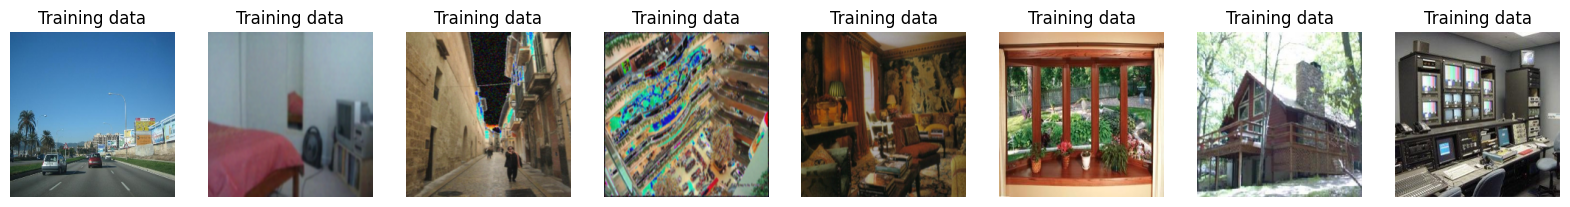

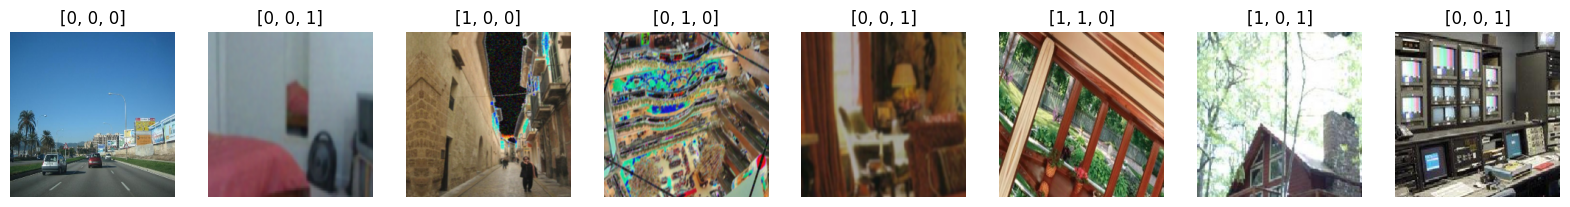

In [ ]:
## To Do  : show 8 images from train_loader
samples,trans_samples,labels = next(iter(train_loader))
indices = np.arange(8) + np.random.randint(1,6)

plot_multi_image(samples[indices],title='Training data')
plot_multi_image(trans_samples[indices],label=labels[indices])

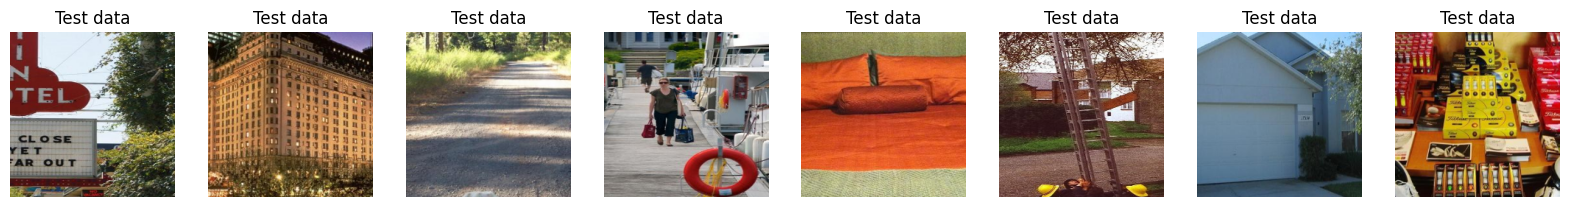

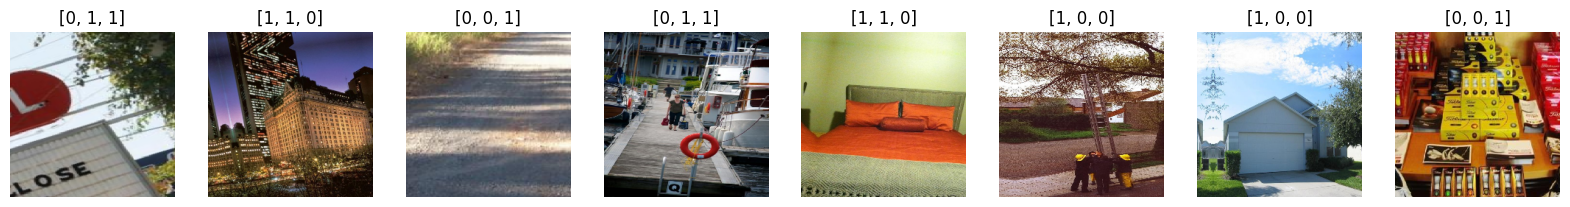

In [ ]:
## To Do  : show 8 images from test_loader
samples,trans_samples,labels = next(iter(test_loader))
indices = np.arange(8) + np.random.randint(1,6)

plot_multi_image(samples[indices],title='Test data')
plot_multi_image(trans_samples[indices],label=labels[indices])

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

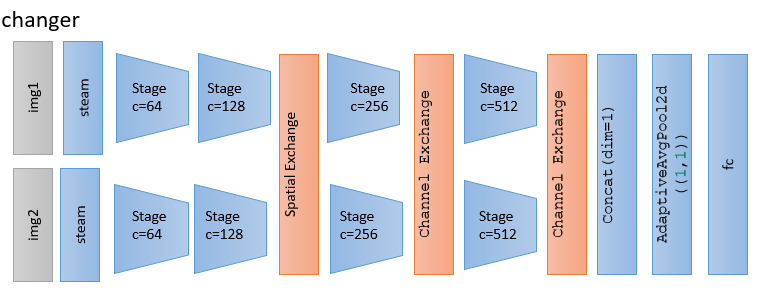

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


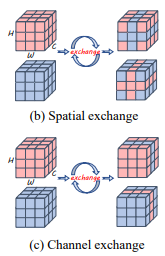

In [ ]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

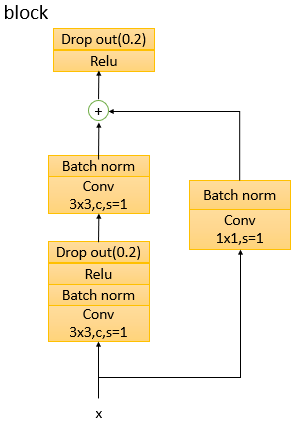

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





In [ ]:
##To Do
class block(nn.Module):
  def __init__(self,in_channels, out_channels):
    super(block,self).__init__()
    # Define the layers
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1)
    self.batchnorm1 = nn.BatchNorm2d(out_channels)
    self.dropout = nn.Dropout2d(p=0.2)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,padding=1)
    self.batchnorm2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()

    self.conv2_residual = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    self.batchnorm_residual = nn.BatchNorm2d(out_channels)


  def forward(self,x):
    out = self.conv1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.conv2(out)
    out = self.batchnorm2(out)

    out_skip = self.conv2_residual(x)
    out_skip = self.batchnorm_residual(out_skip)
    # Add skip connection
    out = out + out_skip
    out = self.relu(out)
    out = self.dropout(out)

    return out

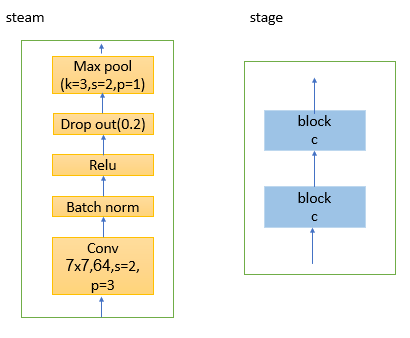

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [ ]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange,in_channels):
    super(changer,self).__init__()
    self.in_channels = in_channels
    self.SpatialExchange = SpatialExchange()
    self.ChannelExchange1 = ChannelExchange()
    self.ChannelExchange2 = ChannelExchange()
    self.block = block

    self.steam=nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=7,padding=3,stride=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(kernel_size=3,padding=1,stride=2)
        )

    self.stage1 = self._make_stage(64)
    self.stage2 = self._make_stage(128)
    self.stage3 = self._make_stage(256)
    self.stage4 = self._make_stage(512,same_channel=True)

    self.AdaptiveAvgPool2d = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(1024, 3)
    self.sigmoid = nn.Sigmoid()


  def _make_stage(self,out_channels,same_channel=False):
    if same_channel :
      layers=[self.block(out_channels,out_channels),self.block(out_channels,out_channels)]
    else:
      layers=[self.block(out_channels,out_channels),self.block(out_channels,out_channels*2)]

    return nn.Sequential(*layers)




  def forward(self,x1,x2):
    o1 = self.steam(x1)
    o1 = self.stage1(o1)
    o1 = self.stage2(o1)

    o2 = self.steam(x2)
    o2 = self.stage1(o2)
    o2 = self.stage2(o2)

    o1,o2 = self.SpatialExchange(o1,o2)

    o1 = self.stage3(o1)
    o2 = self.stage3(o2)

    o1 ,o2 = self.ChannelExchange1(o1,o2)

    o1 = self.stage4(o1)
    o2 = self.stage4(o2)

    o1 ,o2 = self.ChannelExchange2(o1,o2)

    out = torch.concat([o1,o2],dim=1)
    out = self.AdaptiveAvgPool2d(out)
    out = out.view(out.shape[0],-1)
    out = self.fc(out)
    out = self.sigmoid(out)

    return out

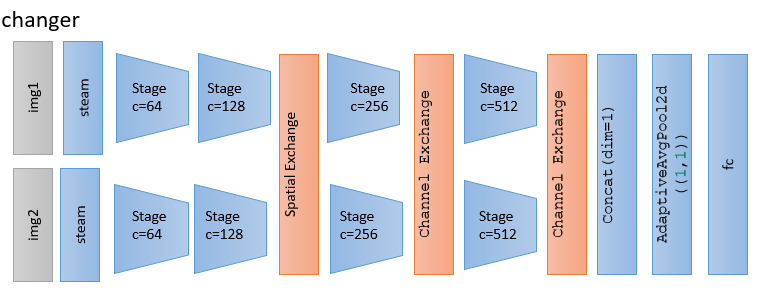

In [ ]:
model = changer(block,SpatialExchange,ChannelExchange,in_channels=3).to(device)

In [ ]:
img, augmented_img, label = next(iter(train_loader))

print('\n',img.shape, augmented_img.shape, label.shape)


 torch.Size([16, 3, 224, 224]) torch.Size([16, 3, 224, 224]) torch.Size([16, 3])


In [ ]:
model(img.to(device).float(), augmented_img.to(device).float()).shape

torch.Size([16, 3])

In [ ]:
# torch.cuda.empty_cache()
# !pip install numba

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()


In [ ]:
## To Do
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model=changer(block,SpatialExchange,ChannelExchange,224).to(device)

# citeration = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


##Train & validation


In [ ]:

# Loss_train=[]
# Loss_val=[]

# print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')



In [ ]:
def get_data_loaders(train_data_loader, test_data_loader):
    dataloaders = {
        'train': train_data_loader,
        'val': test_data_loader}
    return dataloaders

def calc_loss(pred, target,metrics, criterion):
    loss = criterion(pred, target)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    return loss


def print_metrics(metrics, epoch_samples, phase, temp):
    outputs = []
    print(f'{phase} phase :')
    all_metrics = ['precision','recall','f1','loss','displacement accuracy',
                   'rotation accuracy','scaling accuracy']

    for index,a in enumerate(temp):
      if index != 3:
        outputs.append("{} = {:4f}".format(all_metrics[index],a*100))
      if index >= 3:
        outputs.append('\n')

    outputs.append(f"Loss = {metrics['loss'] / epoch_samples}")
    print(", ".join(outputs),'\n')



In [ ]:
def train_model(model, optimizer, scheduler, num_epochs=20):
    output_metrics = {'f1':{'train':[],
                            'val':[]},
                      'precision':{'train':[],
                                    'val':[]},
                      'recall':{'train':[],
                                'val':[]},
                      'loss':{'train':[],
                              'val':[]},
                      'accuracy_displacement':{'train':[],
                              'val':[]},
                      'accuracy_rotation':{'train':[],
                              'val':[]},
                      'accuracy_scaling':{'train':[],
                              'val':[]},
                      }

    all_metrics = ['precision','recall','f1','loss','accuracy_displacement',
                   'accuracy_rotation','accuracy_scaling']


    dataloaders = get_data_loaders(train_loader,val_loader)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    epoch_loss = 0
    losses = []
    criterion = torch.nn.BCELoss()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            all_predicted = []
            all_targets = []
            accuracy_displacement = 0.0
            accuracy_rotation = 0.0
            accuracy_scaling = 0.0

            for index,(img, augmented_img, labels) in enumerate(tqdm(dataloaders[phase])):
                img = img.to(device).float()
                augmented_img = augmented_img.to(device).float()
                labels = labels.to(device).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(img,augmented_img)
                    loss = calc_loss(outputs, labels, metrics, criterion)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                predicted = (outputs > 0.5).float()
                # [displacement, rotation, scaling]

                accuracy_displacement += (accuracy_score(
                                predicted[:,0].cpu().numpy(),
                                labels[:,0].cpu().numpy() ) * labels.shape[0])

                accuracy_rotation += (accuracy_score(
                                predicted[:,1].cpu().numpy(),
                                labels[:,1].cpu().numpy() ) * labels.shape[0])

                accuracy_scaling += (accuracy_score(
                                predicted[:,2].cpu().numpy(),
                                labels[:,2].cpu().numpy() ) * labels.shape[0])

                all_predicted.extend(predicted.cpu().numpy().flatten())
                all_targets.extend(labels.cpu().numpy().flatten())

                epoch_samples += img.size(0)

            temp = [0,0,0,0,0,0,0]
            temp[0], temp[1], temp[2], _ = precision_recall_fscore_support(all_targets, all_predicted, average='binary')
            temp[3] = metrics['loss'] / epoch_samples
            temp[4] = accuracy_displacement / epoch_samples
            temp[5] = accuracy_rotation / epoch_samples
            temp[6] = accuracy_scaling / epoch_samples

            for index,metric in enumerate(all_metrics):
              output_metrics[metric][phase].append(temp[index])

            print_metrics(metrics, epoch_samples, phase,temp)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        # save the checkpoint
        checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(checkpoint, f'/content/drive/My Drive/DEEP/HW3/Q3/checkpoints/model_checkpoint{epoch}.pth')

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,output_metrics

In [ ]:
best_model,output_metrics = train_model(model, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:45<00:00,  1.50s/it]


train phase :
precision = 54.380665, recall = 44.469783, f1 = 48.928385, 
, displacement accuracy = 59.741211, 
, rotation accuracy = 53.881836, 
, scaling accuracy = 67.114258, 
, Loss = 0.6531611441751011 



100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


val phase :
precision = 60.861865, recall = 39.883946, f1 = 48.188829, 
, displacement accuracy = 62.800000, 
, rotation accuracy = 54.250000, 
, scaling accuracy = 72.100000, 
, Loss = 0.6003769583702088 

saving best model
14m 5s
Epoch 1/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:37<00:00,  1.48s/it]


train phase :
precision = 57.142857, recall = 50.214961, f1 = 53.455378, 
, displacement accuracy = 64.880371, 
, rotation accuracy = 54.064941, 
, scaling accuracy = 69.323730, 
, Loss = 0.6060288102598861 



100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


val phase :
precision = 61.670762, recall = 59.128386, f1 = 60.372820, 
, displacement accuracy = 70.350000, 
, rotation accuracy = 56.850000, 
, scaling accuracy = 73.950000, 
, Loss = 0.5629916644096374 

saving best model
13m 57s
Epoch 2/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:37<00:00,  1.48s/it]


train phase :
precision = 60.317285, recall = 51.587675, f1 = 55.611986, 
, displacement accuracy = 68.969727, 
, rotation accuracy = 54.858398, 
, scaling accuracy = 69.482422, 
, Loss = 0.5955805412959307 



100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


val phase :
precision = 67.755857, recall = 42.220515, f1 = 52.023669, 
, displacement accuracy = 68.950000, 
, rotation accuracy = 57.800000, 
, scaling accuracy = 71.900000, 
, Loss = 0.6237264056205749 

13m 59s
Epoch 3/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:36<00:00,  1.48s/it]


train phase :
precision = 64.002995, recall = 56.813218, f1 = 60.194175, 
, displacement accuracy = 70.568848, 
, rotation accuracy = 60.046387, 
, scaling accuracy = 72.790527, 
, Loss = 0.5687970636645332 



100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


val phase :
precision = 66.448032, recall = 50.595467, f1 = 57.448201, 
, displacement accuracy = 72.400000, 
, rotation accuracy = 59.000000, 
, scaling accuracy = 71.050000, 
, Loss = 0.5603951930999755 

saving best model
13m 57s
Epoch 4/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:36<00:00,  1.48s/it]


train phase :
precision = 65.487006, recall = 59.235547, f1 = 62.204606, 
, displacement accuracy = 71.630859, 
, rotation accuracy = 62.280273, 
, scaling accuracy = 74.133301, 
, Loss = 0.5486774783930741 



100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


val phase :
precision = 69.660411, recall = 59.823484, f1 = 64.368291, 
, displacement accuracy = 76.100000, 
, rotation accuracy = 61.850000, 
, scaling accuracy = 75.750000, 
, Loss = 0.5286479065418244 

saving best model
13m 57s
Epoch 5/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:37<00:00,  1.48s/it]


train phase :
precision = 66.507077, recall = 60.540028, f1 = 63.383425, 
, displacement accuracy = 71.972656, 
, rotation accuracy = 63.854980, 
, scaling accuracy = 74.047852, 
, Loss = 0.5479216682724655 



100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


val phase :
precision = 67.950311, recall = 64.201878, f1 = 66.022933, 
, displacement accuracy = 75.700000, 
, rotation accuracy = 64.450000, 
, scaling accuracy = 75.400000, 
, Loss = 0.5142370588779449 

saving best model
13m 57s
Epoch 6/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:36<00:00,  1.48s/it]


train phase :
precision = 67.571235, recall = 61.185143, f1 = 64.219819, 
, displacement accuracy = 73.425293, 
, rotation accuracy = 63.696289, 
, scaling accuracy = 74.816895, 
, Loss = 0.5397097173263319 



100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


val phase :
precision = 69.082333, recall = 61.842610, f1 = 65.262305, 
, displacement accuracy = 73.950000, 
, rotation accuracy = 63.200000, 
, scaling accuracy = 77.100000, 
, Loss = 0.5403595445156097 

13m 57s
Epoch 7/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:36<00:00,  1.48s/it]


train phase :
precision = 67.928496, recall = 61.553121, f1 = 64.583854, 
, displacement accuracy = 74.597168, 
, rotation accuracy = 64.404297, 
, scaling accuracy = 74.511719, 
, Loss = 0.5352806465816684 



100%|██████████| 125/125 [01:19<00:00,  1.56it/s]


val phase :
precision = 74.680549, recall = 61.592506, f1 = 67.508021, 
, displacement accuracy = 78.850000, 
, rotation accuracy = 67.650000, 
, scaling accuracy = 77.550000, 
, Loss = 0.4910245790481567 

saving best model
13m 56s
Epoch 8/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:40<00:00,  1.49s/it]


train phase :
precision = 68.431816, recall = 60.888719, f1 = 64.440278, 
, displacement accuracy = 75.720215, 
, rotation accuracy = 64.343262, 
, scaling accuracy = 74.279785, 
, Loss = 0.5293808524147607 



100%|██████████| 125/125 [01:21<00:00,  1.54it/s]


val phase :
precision = 65.139616, recall = 58.941966, f1 = 61.886010, 
, displacement accuracy = 66.700000, 
, rotation accuracy = 65.350000, 
, scaling accuracy = 76.000000, 
, Loss = 0.5802009072303772 

14m 2s
Epoch 9/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:36<00:00,  1.48s/it]


train phase :
precision = 69.879518, recall = 61.860775, f1 = 65.626105, 
, displacement accuracy = 76.843262, 
, rotation accuracy = 65.246582, 
, scaling accuracy = 74.841309, 
, Loss = 0.5223287611152045 



100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


val phase :
precision = 71.982379, recall = 63.407062, f1 = 67.423148, 
, displacement accuracy = 77.800000, 
, rotation accuracy = 65.100000, 
, scaling accuracy = 78.150000, 
, Loss = 0.5061634833812714 

13m 57s
Epoch 10/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:36<00:00,  1.48s/it]


train phase :
precision = 70.647923, recall = 63.717827, f1 = 67.004160, 
, displacement accuracy = 78.417969, 
, rotation accuracy = 64.978027, 
, scaling accuracy = 76.245117, 
, Loss = 0.5135606930707581 



100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


val phase :
precision = 73.946886, recall = 64.214712, f1 = 68.738029, 
, displacement accuracy = 79.200000, 
, rotation accuracy = 68.500000, 
, scaling accuracy = 78.850000, 
, Loss = 0.48654174542427064 

saving best model
13m 56s
Epoch 11/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:37<00:00,  1.48s/it]


train phase :
precision = 71.215678, recall = 65.764917, f1 = 68.381848, 
, displacement accuracy = 77.905273, 
, rotation accuracy = 66.333008, 
, scaling accuracy = 77.001953, 
, Loss = 0.5021820534602739 



100%|██████████| 125/125 [01:19<00:00,  1.56it/s]


val phase :
precision = 71.569790, recall = 70.841487, f1 = 71.203777, 
, displacement accuracy = 79.250000, 
, rotation accuracy = 69.550000, 
, scaling accuracy = 78.000000, 
, Loss = 0.48794536614418027 

13m 57s
Epoch 12/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:37<00:00,  1.48s/it]


train phase :
precision = 71.205287, recall = 64.347332, f1 = 67.602828, 
, displacement accuracy = 78.588867, 
, rotation accuracy = 65.441895, 
, scaling accuracy = 76.550293, 
, Loss = 0.5068754366948269 



100%|██████████| 125/125 [01:20<00:00,  1.56it/s]


val phase :
precision = 77.823503, recall = 67.325949, f1 = 72.195122, 
, displacement accuracy = 83.850000, 
, rotation accuracy = 70.250000, 
, scaling accuracy = 80.350000, 
, Loss = 0.4595603582859039 

saving best model
13m 58s
Epoch 13/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:37<00:00,  1.48s/it]


train phase :
precision = 72.178586, recall = 65.793688, f1 = 68.838401, 
, displacement accuracy = 78.723145, 
, rotation accuracy = 66.906738, 
, scaling accuracy = 77.185059, 
, Loss = 0.5010819401359186 



100%|██████████| 125/125 [01:19<00:00,  1.56it/s]


val phase :
precision = 75.970425, recall = 65.005931, f1 = 70.061794, 
, displacement accuracy = 80.600000, 
, rotation accuracy = 68.550000, 
, scaling accuracy = 80.600000, 
, Loss = 0.46308648800849916 

13m 57s
Epoch 14/14
--------------------
LR 0.001


100%|██████████| 512/512 [12:36<00:00,  1.48s/it]


train phase :
precision = 72.306724, recall = 65.348881, f1 = 68.651960, 
, displacement accuracy = 79.321289, 
, rotation accuracy = 67.028809, 
, scaling accuracy = 76.806641, 
, Loss = 0.49708816478960216 



100%|██████████| 125/125 [01:19<00:00,  1.57it/s]

val phase :
precision = 77.376426, recall = 62.784420, f1 = 69.320843, 
, displacement accuracy = 82.050000, 
, rotation accuracy = 67.250000, 
, scaling accuracy = 78.650000, 
, Loss = 0.4661004855632782 

13m 57s
Best val loss: 0.459560


In [ ]:
import pickle

# Save the dictionary to a file1
with open('/content/drive/My Drive/DEEP/HW3/Q3/dictionary_out.pickle', 'wb') as file:
    pickle.dump(output_metrics, file)

In [17]:
def show_results(output_metrics):
    # Create a figure and subplots
    fig, axs = plt.subplots(7,2,figsize=(18,20))
    phase_ = ['Train','Validation']
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for col,phase in enumerate(output_metrics['f1'].keys()):
      for row,metric in enumerate(output_metrics.keys()):
        # plt.figure(figsize=(22, 15))

        axs[row, col].plot(output_metrics[metric][phase], marker='o',markersize=4,c=random.choice(colors))
        # axs[row, col].plot(output_metrics_deform_cov[metric][phase], marker='o',markersize=4,c='r')

        axs[row, col].set_title(f'{phase_[col]} {metric}')
        axs[row, col].set_xlabel('Epoch')
        # plt.ylabel('accuracies')
        # axs[row, col].legend(['Conv','Deformable Conv'])


    plt.tight_layout()
    plt.show()

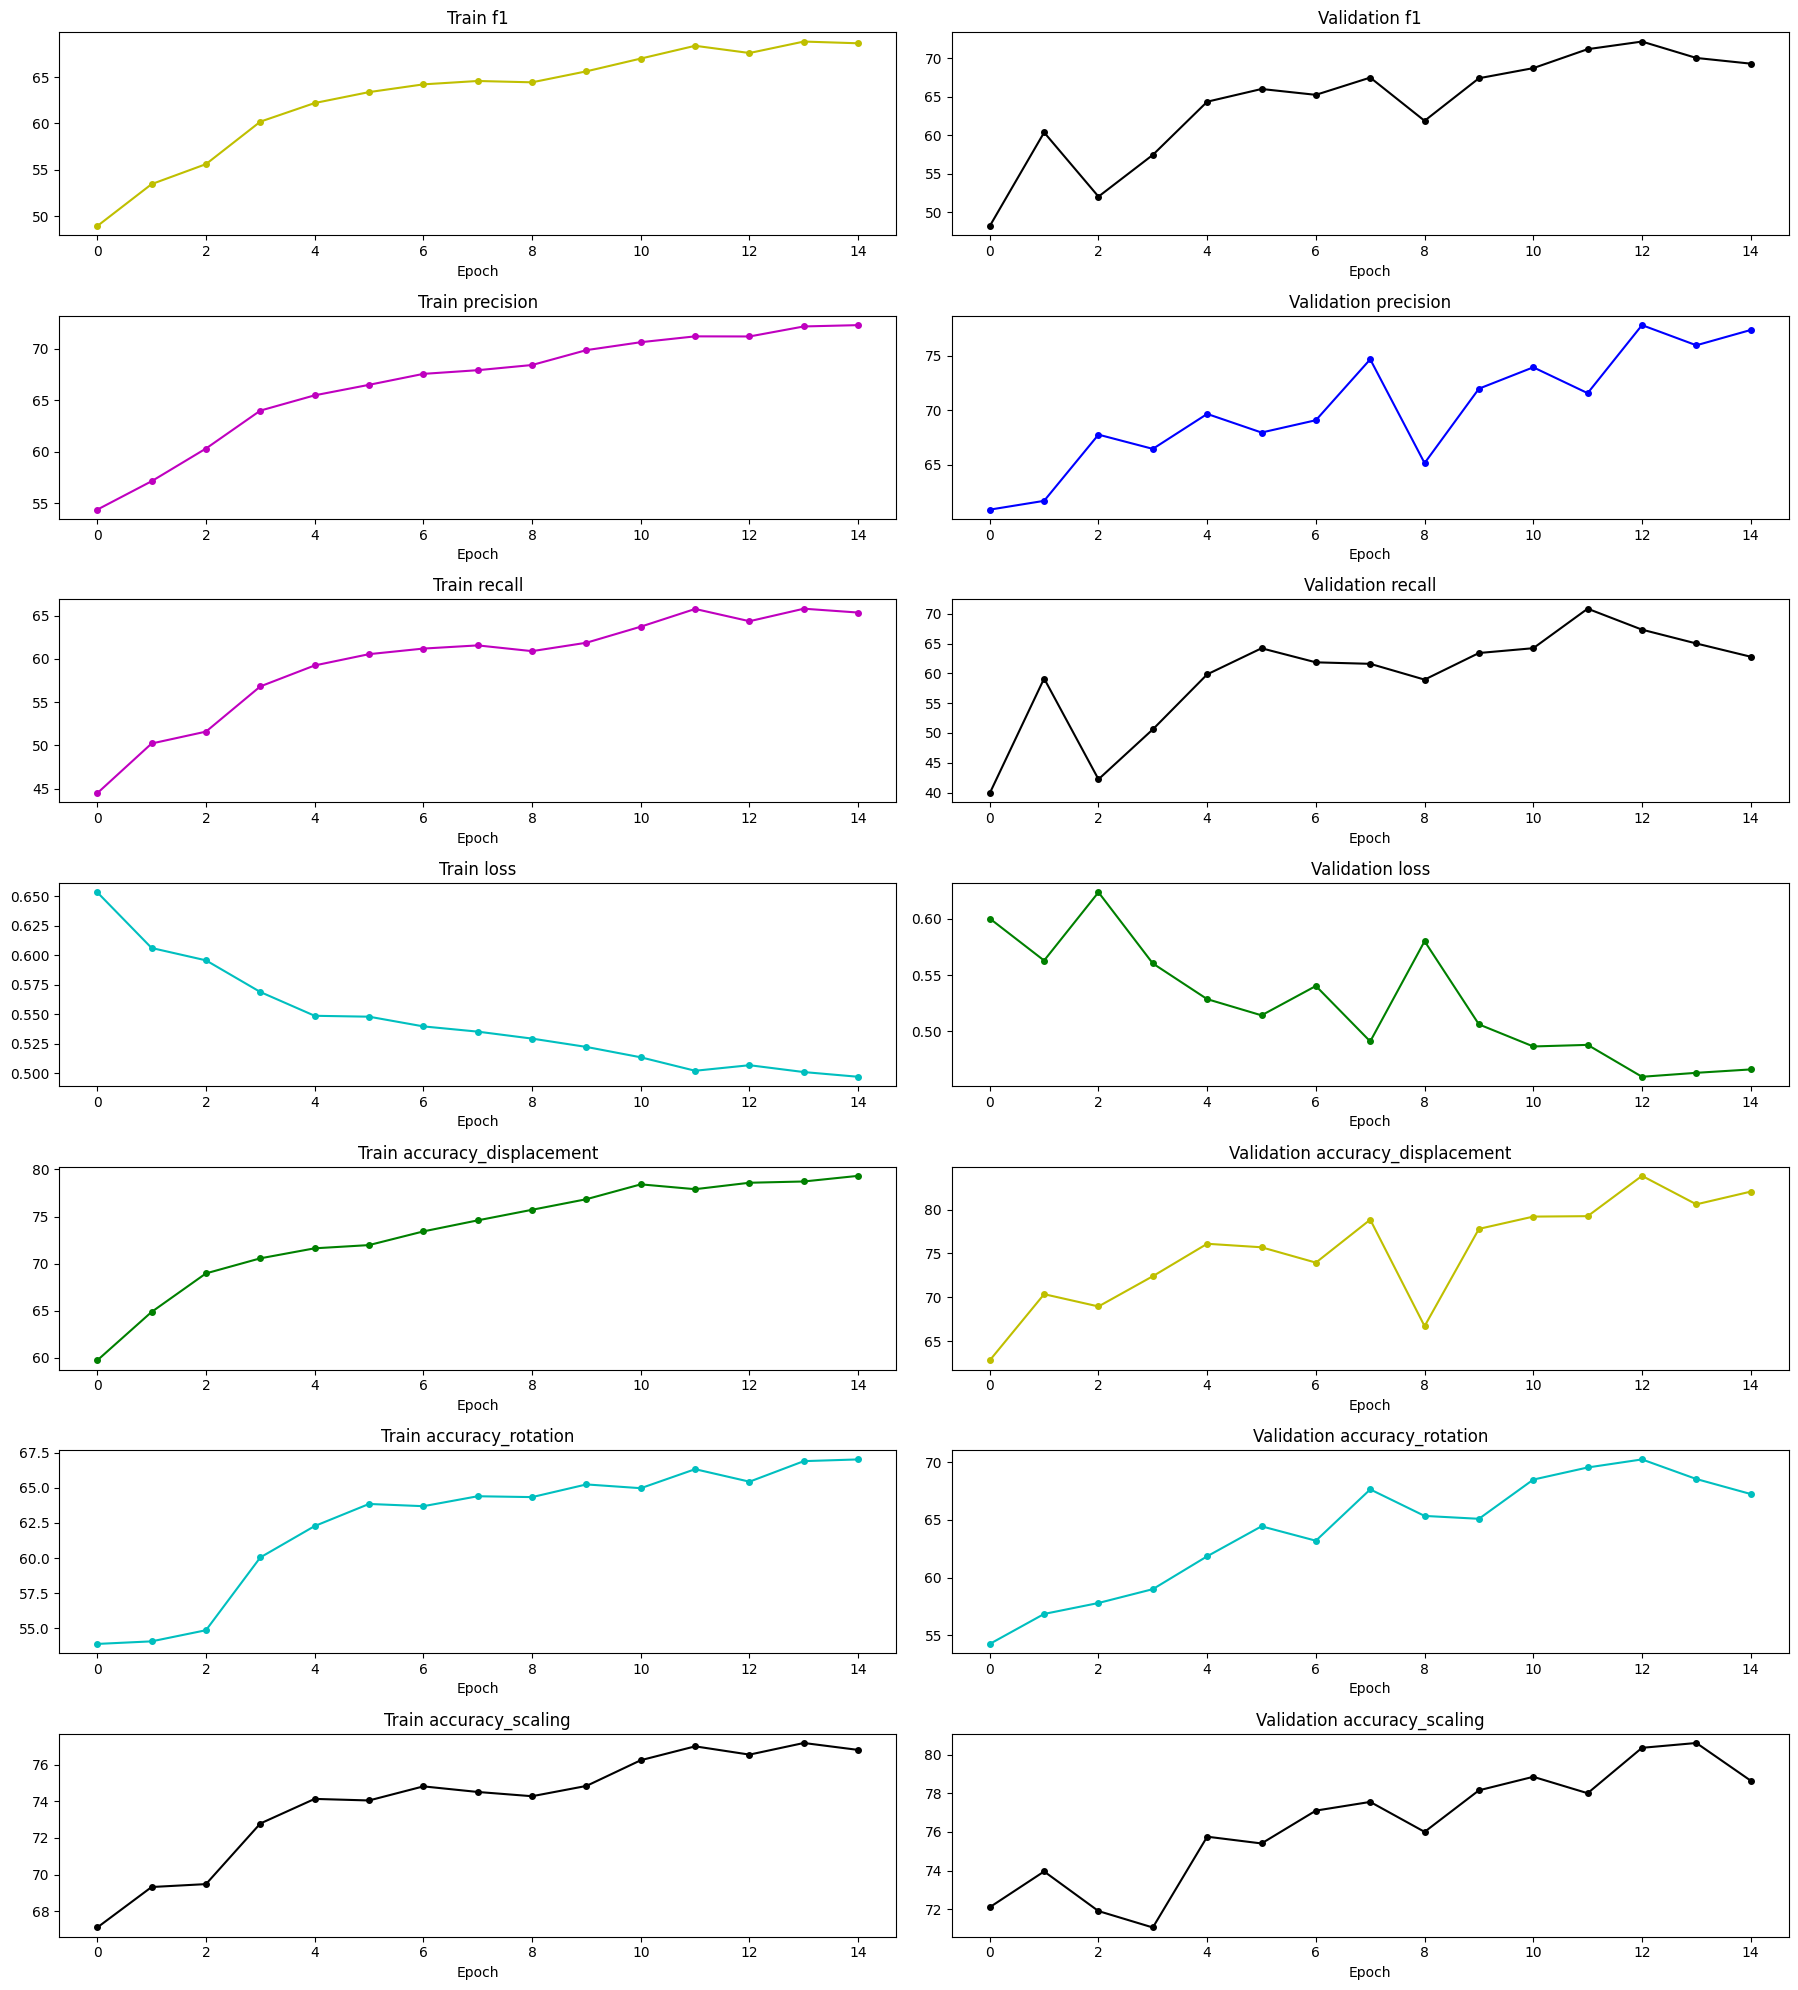

In [20]:
show_results(output_metrics)

# Test


In [ ]:
def test_model(model):

    dataloader = test_loader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = torch.nn.BCELoss()

    model.eval()  # Set model to evaluate mode

    metrics = defaultdict(float)
    epoch_samples = 0

    all_predicted = []
    all_targets = []
    accuracy_displacement = 0.0
    accuracy_rotation = 0.0
    accuracy_scaling = 0.0

    for index,(img, augmented_img, labels) in enumerate(dataloader):
        img = img.to(device).float()
        augmented_img = augmented_img.to(device).float()
        labels = labels.to(device).float()

        # forward
        with torch.no_grad():
            outputs = model(img,augmented_img)
            loss = calc_loss(outputs, labels, metrics, criterion)

        predicted = (outputs > 0.5).float()

        accuracy_displacement += (accuracy_score(
                        predicted[:,0].cpu().numpy(),
                        labels[:,0].cpu().numpy() ) * labels.shape[0])

        accuracy_rotation += (accuracy_score(
                        predicted[:,1].cpu().numpy(),
                        labels[:,1].cpu().numpy() ) * labels.shape[0])

        accuracy_scaling += (accuracy_score(
                        predicted[:,2].cpu().numpy(),
                        labels[:,2].cpu().numpy() ) * labels.shape[0])

        all_predicted.extend(predicted.cpu().numpy().flatten())
        all_targets.extend(labels.cpu().numpy().flatten())

        epoch_samples += img.size(0)

    temp = [0,0,0,0,0,0,0]
    temp[0], temp[1], temp[2], _ = precision_recall_fscore_support(all_targets, all_predicted, average='binary')
    temp[3] = metrics['loss'] / epoch_samples
    temp[4] = accuracy_displacement / epoch_samples
    temp[5] = accuracy_rotation / epoch_samples
    temp[6] = accuracy_scaling / epoch_samples

    print('Test results:\n ')
    print('precision = {:4f}, recall = {:4f}, f1 = {:4f},'.format(temp[0]*100,temp[1]*100,temp[2]*100))
    print('Loss = {:4f}'.format(temp[3]))
    print('displacement accuracy = {:4f}'.format(temp[4]*100))
    print('rotation accuracy = {:4f}'.format(temp[5]*100))
    print('scaling accuracy = {:4f}'.format(temp[6]*100))



In [ ]:

checkpoint = torch.load(f'/content/drive/My Drive/DEEP/HW3/Q3/checkpoints/model_checkpoint{14}.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']


In [24]:
test_model(model)

Test results:
 
precision = 76.334260, recall = 64.654652, f1 = 68.545456,
Loss = 0.451145
displacement accuracy = 83.850000
rotation accuracy = 70.250000
scaling accuracy = 80.350000


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

پاسخ سوالات تعوری و توضیحات در فایل پی دی اف قرار داده شده است


